In [1]:
# --- FID Evaluation using precomputed .pt tensors ---

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from scipy import linalg
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchoptics import visualize_tensor
import matplotlib.colors as colors

from classifiers import *
import matplotlib.pyplot as plt
from collections import Counter

import os
import random
from tqdm import tqdm

In [2]:

def load_real_samples_from_npy(root_folder, max_samples=None, seed=42, allowed_classes=[ 'axion', 'cdm', 'no_sub']):
    """
    Load real samples from a folder of .npy files, optionally filtering by class name.

    Args:
        root_folder (str): Path to folder containing subfolders for each class.
        max_samples (int, optional): Maximum number of samples to load.
        seed (int): Random seed for shuffling.
        allowed_classes (list[str], optional): List of class names to include (e.g., ['axion', 'cdm']).

    Returns:
        torch.Tensor: A tensor of shape (N, C, H, W) of loaded and normalized images.
    """
    all_paths = []
    for class_name in os.listdir(root_folder):
        if allowed_classes and class_name not in allowed_classes:
            continue

        class_dir = os.path.join(root_folder, class_name)
        if not os.path.isdir(class_dir):
            continue

        for fname in os.listdir(class_dir):
            if fname.endswith('.npy'):
                full_path = os.path.join(class_dir, fname)
                all_paths.append((full_path, class_name))

    random.seed(seed)
    random.shuffle(all_paths)

    if max_samples:
        all_paths = all_paths[:max_samples]

    all_imgs = []
    for path, class_name in tqdm(all_paths, desc="Loading real samples"):
        img = np.load(path, allow_pickle=True)

        if 'axion' in class_name.lower():
            img = img[0]

        img = img.astype(np.float32)
        img_min, img_max = img.min(), img.max()
        if img_max - img_min > 1e-8:
            img = (img - img_min) / (img_max - img_min)
        else:
            img = np.zeros_like(img)

        if img.ndim == 2:
            img = img[None, :, :]  # Add channel dim

        all_imgs.append(torch.from_numpy(img))

    return torch.stack(all_imgs)

In [3]:

# ----------------------------------------------------
# Dataset wrapper for .pt tensors
# ----------------------------------------------------
class TensorDataset(Dataset):
    def __init__(self, tensor):
        self.data = tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], 0  # dummy label

# ----------------------------------------------------
# Activation & FID functions
# ----------------------------------------------------
def get_activations(dataloader, model, device):
    model.eval()
    activations = []
    with torch.no_grad():
        for x, _ in tqdm(dataloader):
            x = x.to(device)
            feat = model(x)
            activations.append(feat.cpu().numpy())
    return np.concatenate(activations, axis=0)

def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(0), np.cov(act2, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)

from scipy.ndimage import median_filter

def apply_median_filter(tensor_imgs, size=5):
    # tensor_imgs: shape [B, 1, H, W] → return same shape
    cleaned = []
    for img in tensor_imgs:
        np_img = img.squeeze().cpu().numpy()
        np_img = median_filter(np_img, size=size)
        cleaned.append(torch.tensor(np_img).unsqueeze(0))  # [1, H, W]
    return torch.stack(cleaned)  # [B, 1, H, W]

def normalize_images(tensor):
    # tensor: [B, H, W] or [B, 1, H, W]
    if tensor.dim() == 4:
        tensor = tensor.squeeze(1)  # [B, H, W]
    normed = []
    for img in tensor:
        min_val = img.min()
        max_val = img.max()
        normed_img = (img - min_val) / (max_val - min_val + 1e-8)
        normed_img = normed_img.unsqueeze(0)# + 1e-8)
        normed.append(normed_img)
    return torch.stack(normed)

In [4]:

# ----------------------------------------------------
# Load and evaluate
# ----------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

# Load your .pt files
gen_tensor  = torch.load("./samples/generated_samples_model_II_550_epochs_lin+cos_10000.pt").float()
# gen_tensor  = torch.load("./samples/generated_samples_model_II_300_epochs.pt").float()
real_tensor = load_real_samples_from_npy("./Model_II_test/", max_samples=gen_tensor.shape[0], seed = 10)
real_tensor2 = load_real_samples_from_npy("./Model_II/", max_samples=gen_tensor.shape[0], seed = 11)


# --- Subsample real set to match generated set size ---
if real_tensor.shape[0] > gen_tensor.shape[0]:
    n_gen = gen_tensor.shape[0]
    
    indices = torch.randperm(real_tensor.shape[0])[:n_gen]
    real_tensor = real_tensor[indices]
    
    print(f"Subsampled real set to {n_gen} examples")

Loading real samples: 100%|██████████| 10000/10000 [00:02<00:00, 4053.31it/s]


In [5]:

# gen_tensor = F.interpolate(gen_tensor, size=(120, 120), mode='bilinear', align_corners=False)
# gen_tensor = F.interpolate(gen_tensor, size=(150, 150), mode='bilinear', align_corners=False)
# gen_tensor_my = F.interpolate(gen_tensor_my, size=(150, 150), mode='bilinear', align_corners=False)

gen_tensor = normalize_images(gen_tensor)
real_tensor = normalize_images(real_tensor) 
real_tensor2 = normalize_images(real_tensor2) 

print(real_tensor.shape)
print(gen_tensor.shape)

torch.Size([10000, 1, 64, 64])
torch.Size([10000, 1, 64, 64])


In [6]:

real_loader = DataLoader(TensorDataset(real_tensor), batch_size=BATCH_SIZE, shuffle=False)
real_loader2 = DataLoader(TensorDataset(real_tensor2), batch_size=BATCH_SIZE, shuffle=False)

gen_loader  = DataLoader(TensorDataset(gen_tensor), batch_size=BATCH_SIZE, shuffle=False)

### Plot examples

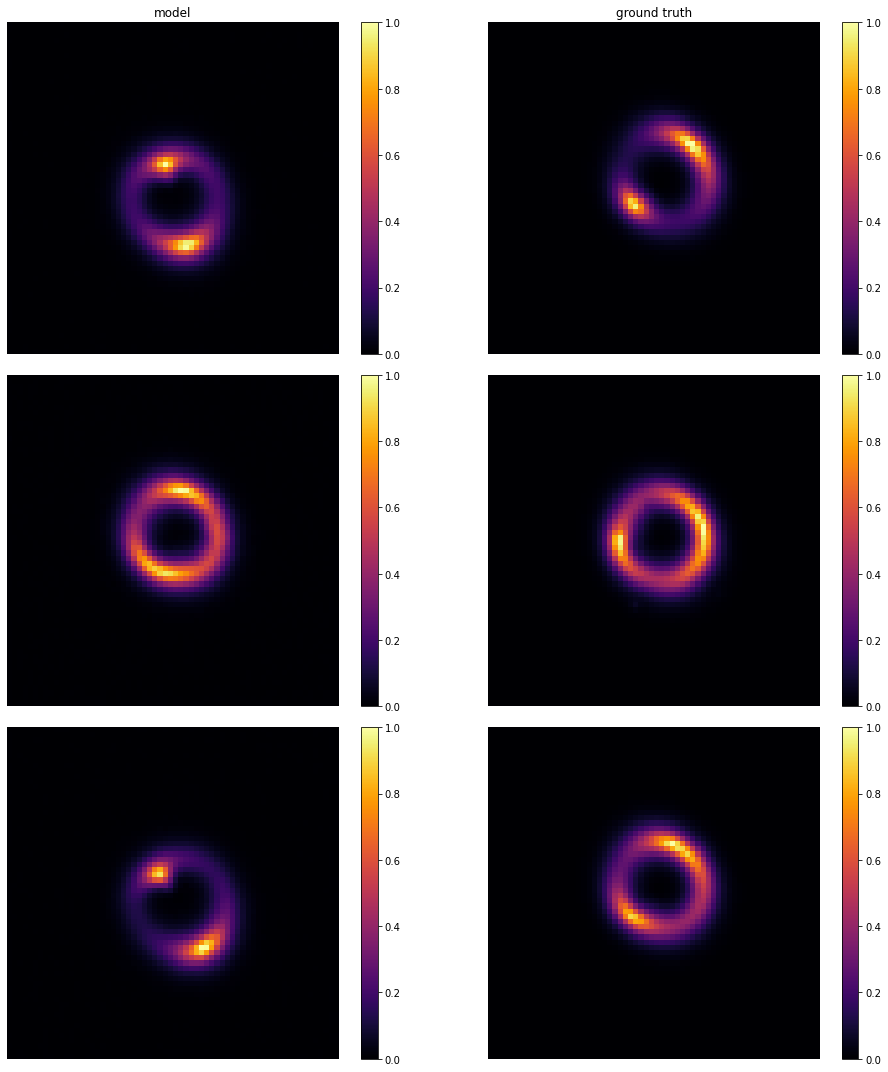

In [8]:
num_samples = 3

# Create subplots: 10 rows, 2 columns
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(15, 5 * num_samples))

titles = ["model",  "ground truth"]

for i in range(num_samples):
    for j, tensor in enumerate([gen_tensor[i], real_tensor[i]]):
        ax = axes[i, j]
        img = tensor.squeeze().cpu().numpy()  # convert tensor to numpy array
        im = ax.imshow(img, cmap='inferno')  # change cmap to match your color style
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if i == 0:
            ax.set_title(titles[j], fontsize=12)

plt.tight_layout()
plt.show()

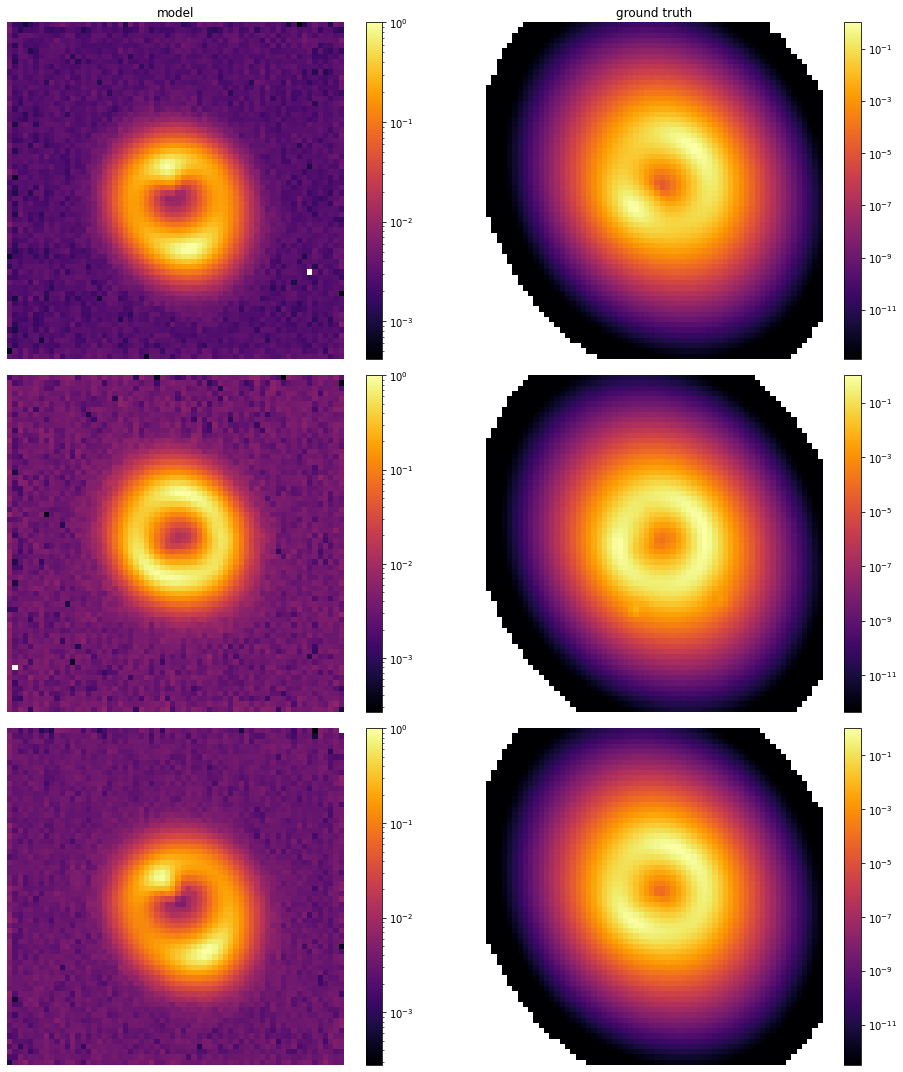

In [7]:
num_samples = 3

# Create subplots: 10 rows, 2 columns
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(15, 5 * num_samples))

titles = ["model",  "ground truth"]

for i in range(num_samples):
    for j, tensor in enumerate([gen_tensor[i], real_tensor[i]]):
        ax = axes[i, j]
        img = tensor.squeeze().cpu().numpy()  # convert tensor to numpy array
        im = ax.imshow(img, cmap='inferno', norm=colors.LogNorm())  # change cmap to match your color style
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if i == 0:
            ax.set_title(titles[j], fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
# Load full classifier
model = ResNet18GrayscaleFD(num_classes=3, bottleneck_dim=512, use_classifier = False).to(DEVICE)
model.load_state_dict(torch.load("./classifier_weights/noisy_classifier_512.pt"), strict = False)

# model = get_resnet18_grayscale(num_classes=3, dropout_p=0).to(DEVICE)
# Remove final classification head for FID
# model.fc = nn.Identity()

model.eval()

ResNet18GrayscaleFD(
  (backbone): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
# Extract features and compute FID
act_real = get_activations(real_loader, model, DEVICE)
act_real2 = get_activations(real_loader2, model, DEVICE)
act_gen  = get_activations(gen_loader, model, DEVICE)

print(act_gen.shape)


100%|██████████| 157/157 [00:00<00:00, 385.82it/s]


In [ ]:
fid = calculate_fid(act_real, act_gen)
print(f"Generated images FD score: {fid:.4f}")

fid = calculate_fid(act_real, act_real2)
print(f"Real images FD score: {fid:.4f}")

Generated images FD score: 17.1833
Real images FD score: 1.0714


### Plot the feature distributions

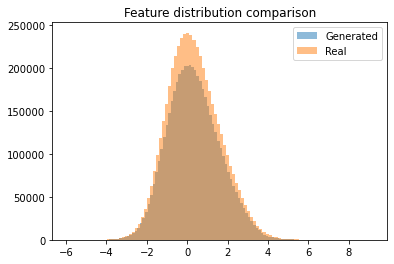

In [13]:
plt.hist(act_gen.flatten(),  bins=100, alpha=0.5, label="Generated")
plt.hist(act_real.flatten(), bins=100, alpha=0.5, label="Real")
# plt.hist(act_gen.flatten(),  bins=100, alpha=0.5, label="Generated")
plt.legend()
plt.title("Feature distribution comparison")
plt.show()

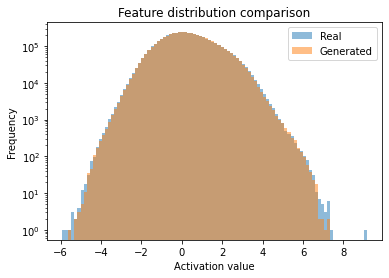

In [14]:
# Flatten and concatenate both datasets to compute shared range
all_data = np.concatenate([act_real.flatten(), act_gen.flatten()])
bins = np.linspace(all_data.min(), all_data.max(), 101)  # 100 bins => 101 edges

plt.hist(act_real.flatten(), bins=bins, alpha=0.5, label="Real")
plt.hist(act_gen.flatten(),  bins=bins, alpha=0.5, label="Generated")
plt.legend()
# plt.xlim(0,30)
plt.title("Feature distribution comparison")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

### Classification statistics

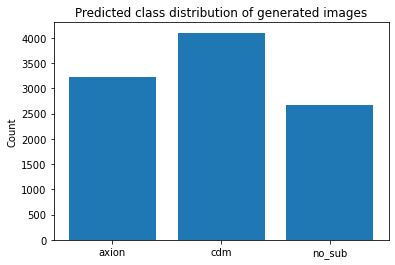

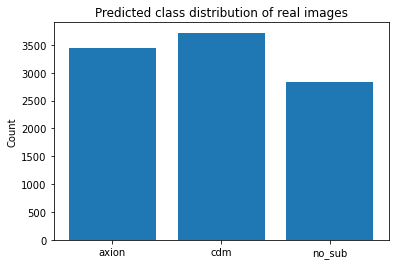

In [ ]:
# Load trained classifier (set .fc = original, not nn.Identity)
classifier = ResNet18GrayscaleFD(num_classes=3, bottleneck_dim = 512)
classifier.load_state_dict(torch.load("./classifier_weights/noisy_classifier_512.pt"))
classifier = classifier.to('cpu').eval()

# Predict classes
with torch.no_grad():
    outputs = classifier(gen_tensor)
    preds = outputs.argmax(dim=1).cpu().numpy()

# Plot histogram of predicted classes
counts = Counter(preds)
labels = ['axion', 'cdm', 'no_sub']  # adjust if needed
class_ids = [0, 1, 2]
freqs = [counts.get(i, 0) for i in class_ids]

plt.bar(labels, freqs)
plt.title("Predicted class distribution of generated images")
plt.ylabel("Count")
plt.show()

with torch.no_grad():
    outputs = classifier(real_tensor)
    preds = outputs.argmax(dim=1).cpu().numpy()

# Plot histogram of predicted classes
counts = Counter(preds)
labels = ['axion', 'cdm', 'no_sub']  # adjust if needed
class_ids = [0, 1, 2]
freqs = [counts.get(i, 0) for i in class_ids]

plt.bar(labels, freqs)
plt.title("Predicted class distribution of real images")
plt.ylabel("Count")
plt.show()
